# Analyzing the Impact of Immigration on Unemployment

My hypothesis is that immigration is positively correlated to the unemployment rate for the following years (that is why I chose to analyze 2 consecutive years instead of taking a wide range).  Thus, my task is to make a regression model which will help to confirm or reject this hypothesis. In addition, I want to analyze whether such factors as GDP, the existence of an officially set minimum wage, and social protection have an impact on the unemployment rate.

In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

We decided to use the official database of the European Commission called Eurostat and took 5 different factors:
* unemployment rate (as the ratio of the number of people who are not employed and who are actively seeking employment to the total number of people in the labor force)
* GDP growth rate (as a percentage)
* the existence of minimum wage (a boolean variable that will depend on whether a country has an official set minimum wage or not)
* expenditure on social protection (as a percentage of GDP)
* immigration rate (as a percentage, the number of immigrants divided by total population)

The data I used is for European countries and for the years 2011 and 2012 because these were years with increased rates of immigration. It is important to note that immigration does not have an instant effect on statistics. Therefore, to make my prediction more accurate, I take unemployment rates one year after the immigration (for example, if I take immigration for 2011, then the corresponding value for unemployment will be taken from data for 2012). 

In [ ]:
df_img = pd.read_csv("immigration.csv")
df_gdp = pd.read_csv("GDP.csv")
df_wages = pd.read_csv("minimum_wages.csv")
df_sp = pd.read_csv("social_protection.csv")
df_unemp = pd.read_csv("unemployment_rate.csv")

In [ ]:
df_img.rename(columns = {'OBS_VALUE':'immigration rate'}, inplace = True)
df_gdp.rename(columns = {'OBS_VALUE':'GDP growth'}, inplace = True)
df_wages.rename(columns = {'OBS_VALUE':'minimum wage'}, inplace = True)
df_sp.rename(columns = {'OBS_VALUE':'social protection'}, inplace = True)
df_unemp.rename(columns = {'OBS_VALUE':'unemployment rate'}, inplace = True)
df_wages['minimum wage'] = df_wages['minimum wage'].fillna(0).astype("bool").astype("int")

In [ ]:
pd.concat(
    [
     df_img["immigration rate"].describe(percentiles=[.05, .25, .5, .75, .95]),
     df_gdp["GDP growth"].describe(percentiles=[.05, .25, .5, .75, .95]),
     df_wages["minimum wage"].describe(percentiles=[.05, .25, .5, .75, .95]),
     df_sp["social protection"].describe(percentiles=[.05, .25, .5, .75, .95]),
     df_unemp["unemployment rate"].describe(percentiles=[.05, .25, .5, .75, .95])
    ],
    axis=1,
).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
immigration rate,26.0,104139.846154,135919.663865,3709.0,4988.000,16680.500,41157.00,143062.25,382177.500,489422.0
GDP growth,26.0,1.542308,3.072611,-10.1,-1.475,0.750,1.75,2.60,5.700,7.3
minimum wage,26.0,0.730769,0.452344,0.0,0.000,0.250,1.00,1.00,1.000,1.0
social protection,26.0,23.861538,5.535419,15.1,15.775,19.075,24.55,28.55,32.300,33.5
unemployment rate,26.0,10.911538,5.324985,4.9,5.175,7.150,9.90,13.85,22.375,24.8


* Mean: shows the avarage of all data. Basically it is  the sum of the values divided by the number of values.
* Median: shows what the value is in the middle of the data, on the N/2 position. (where N - number of values).  The second quartile.
* Upper quartile: value under which 75% of data points are found when arranged in increasing order. 
* Lower quartile: the value under which 25% of data points are found when they are arranged in increasing order.
* Upper and lower 5%-quantiles: values under which 95% and 5% of data (correspondingly) points are found when arranged in increasing order. 

We have also added columns that will be used in different OLS models to simplify calculations later:

In [ ]:
data = [
        df_img["geo"],
        df_unemp["unemployment rate"],
        df_img["immigration rate"],
        df_gdp["GDP growth"],
        df_sp["social protection"],
        df_wages["minimum wage"]
]
headers = ["country",  "unemployment_rate", "immigration_rate", "GDP_growth", "social_protection", "minimum_wage"]
df = pd.concat(data, axis=1, keys=headers)
df["log_unemployment_rate"] = np.log(df["unemployment_rate"])
df["log_immigration_rate"] = np.log(df["immigration_rate"])


df["minwage*log(imm)"] = df["minimum_wage"]*np.log(df["immigration_rate"])
df

,country,unemployment_rate,immigration_rate,GDP_growth,social_protection,minimum_wage,log_unemployment_rate,log_immigration_rate,minwage*log(imm)
0,AT,4.9,82230,2.9,28.8,0,1.589235,11.317275,0.000000
1,BE,7.6,147377,1.7,29.9,1,2.028148,11.900749,11.900749
2,CY,11.9,23037,0.4,20.1,0,2.476538,10.044857,0.000000
3,CZ,7.0,27114,1.8,19.9,1,1.945910,10.207805,10.207805
4,DE,5.4,489422,3.9,28.8,0,1.686399,13.100980,0.000000
5,DK,7.8,52833,1.3,33.5,0,2.054124,10.874891,0.000000
6,EE,10.0,3709,7.3,15.5,1,2.302585,8.218518,8.218518
7,EL,24.5,60089,-10.1,27.8,1,3.198673,11.003582,11.003582
8,ES,24.8,371331,-0.8,25.5,1,3.210844,12.824849,12.824849
9,FI,7.7,29481,2.5,28.7,0,2.041220,10.291501,0.000000


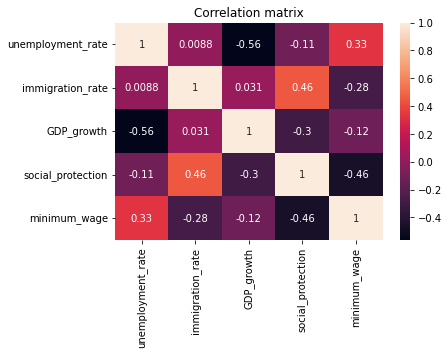

In [ ]:
df_cur = pd.DataFrame(df, columns = [ "unemployment_rate", "immigration_rate", "GDP_growth", "social_protection", "minimum_wage"])

corrMatrix = df_cur.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation matrix")
plt.show()



General terms that are important for analysis of my regression models:

*   $R-squared$: is a statistical measure of how close the data are to the fitted regression line.  It is the percentage of the response variable variation that is explained by a linear model. It is expressed as a percentage between 0 and 100, with 100 signaling perfect correlation and zero no correlation at all.
*   $Adjusted$ $R-squared$: provides a more precise view of that correlation by also taking into account how many independent variables are added to a particular model, which tend to skew the results of R-squared measurements. It is always lower than the R-squared.

*    The residual standard error: measures the standard deviation of the residuals in a regression model. The smaller the residual standard error, the better a regression model fits a dataset. It is calcilated as:

  $Residual$ $standart$ $error$ $=$ $\sqrt{\sum(y - \hat{y})^2 / df}$

  where:

  $y$: The observed value

  $\hat{y}$: The predicted value

  $df$: The degrees of freedom, calculated as the total number of observations – total number of model parameters.

*   $F-statistic$: is the result of a F-test where the null hypothesis is that all of the regression coefficients are equal to zero. Is shows whether ymy added coefficients improved the model. If the result is big enough I can conclude that coefficients I included improved model's fit. The F-value which I receive from F-statistis should always be considered along with the p-value. If you get a large f value, it means something is significant, while a small p value means all ymy results are significant. The F-statistic just compares the joint effect of all the variables together. 

* $log-likelihood$ value is one a the ways to measure the goodness of fit. The higher the value of the log-likelihood, the better a model fits a dataset. Adding more predictor variables to a model will almost always increase the log-likelihood value even if they are not statistically significant.

*  $Akaike$ $information$ $criterion$: is an  estimator of prediction error. It estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model. The formula for AIC is

  $AIC = 2K - 2ln(L)$

  where $K$ -  number of independent variables, $L$ - log-likelihood estimate.

* $P-value$  shows the lowest significance level at which I can reject null hypothesis


--------------------------------------------------------------------------------
###OLS models

In [ ]:
mod = smf.ols(formula='log_unemployment_rate ~ log_immigration_rate', data=df)

res = mod.fit()

print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     log_unemployment_rate   R-squared:                       0.017
Model:                               OLS   Adj. R-squared:                 -0.024
Method:                    Least Squares   F-statistic:                    0.4154
Date:                   Wed, 01 Jun 2022   Prob (F-statistic):              0.525
Time:                           19:29:24   Log-Likelihood:                -15.404
No. Observations:                     26   AIC:                             34.81
Df Residuals:                         24   BIC:                             37.32
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
In

The first regression model coefficient shows negative relationship between unemployment rate and immigration one. However, it is really small, which means that there is not much correlation between them. To be more precise, a 1% increase in the immigration ratio results into a 0.04% decrease in unemployment rate for the following year. 

However, R-squared for this regression model, which is very simple compared to others, is small. That indicates that my estimated model is far from ideal model. Adjusted R-squared, as expected, shows the same tendency - it is negative so the model is far from what I are looking for. F-statistic confirms this - it is as low as 0.4154, which indicates that most likely immigration does not affect unemployment rate.

The t-­test shows that the lowest level at which I can reject the null hypothesis is 0.525, thus I will most probably accept it (that coefficient for immigration rate is equal to 0). 
Moreover, AIC is quite big.

--------------------------------------------------------------------------------

For my first multiple regression model, I added GDP growth as an independent variable to account for the economic differences between countries in the sample.

In [ ]:
mod = smf.ols(formula='log_unemployment_rate ~ log_immigration_rate + GDP_growth', data=df)

res = mod.fit()

print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     log_unemployment_rate   R-squared:                       0.231
Model:                               OLS   Adj. R-squared:                  0.164
Method:                    Least Squares   F-statistic:                     3.450
Date:                   Wed, 01 Jun 2022   Prob (F-statistic):             0.0489
Time:                           19:28:34   Log-Likelihood:                -12.216
No. Observations:                     26   AIC:                             30.43
Df Residuals:                         23   BIC:                             34.21
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
In

It shows negative relationship between both GDP growth and percent changes in immigration percent changes in unemployment. We obtain that as GDP growth increases by one percentage point, unemployment decreases by 6.8% with a significance level of 1,9%. This is expected, though: economic
growth leads to the creation of jobs and thus increases unemployment significantly. My coefficient on immigration did not change much from the first to the second model, but it gained in significance, at it is
now statistically significant at 34% (which also leads us to conclusion to accept the null hypothesis). 

R-squared is not very high, as well as in the first model, which tells that model is not really good. With adjusted R-squared is the same situation. F-statistics is bigger than in the prevoius model, although not really high, so the variable I included (GDP growth) improved model's fit, but not significantly.
The p-value of t-test of GDP growth equals to 1,9%. Thus the coefficient for it should not be equal to 0. AIC is smaller that in the first model. So this one is better for sure.


--------------------------------------------------------------------------------

For my third model, I added the binary variable minimum wage. Minimum wage can have negative effect on unemployment because it drives out of the job market low­productivity workers who would have been willing to work for a low wage. We also think that adding the minimum wage will have an effect on the coefficient on immigration, because a minimum wage might attract more immigrants. 

In [ ]:
mod = smf.ols(formula='log_unemployment_rate ~ log_immigration_rate + GDP_growth + minimum_wage', data=df)

res = mod.fit()

print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     log_unemployment_rate   R-squared:                       0.290
Model:                               OLS   Adj. R-squared:                  0.193
Method:                    Least Squares   F-statistic:                     2.996
Date:                   Wed, 01 Jun 2022   Prob (F-statistic):             0.0526
Time:                           19:28:34   Log-Likelihood:                -11.173
No. Observations:                     26   AIC:                             30.35
Df Residuals:                         22   BIC:                             35.38
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
In

R-squared is higher than in prevoius model, it shows us that the model has improved with the dummy variable (minimum wage). Although F-statistics became smaller than in the second model. The p-value of t-test of GDP growth equals to 3%. Thus as well as in the second model, the coefficients should not be equal to 0. AIC became smaller, but it did not signficantelly affect the model.

--------------------------------------------------------------------------------


In the next model, I test if the minimum wage has an effect not only on the average unemployment rate but also on the coefficient on immigration. We therefore add the variable minwage*log(immigration) to my regression:

In [ ]:
mod = smf.ols(formula='log_unemployment_rate ~ log_immigration_rate + minimum_wage*log_immigration_rate', data=df)

res = mod.fit()

print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     log_unemployment_rate   R-squared:                       0.126
Model:                               OLS   Adj. R-squared:                  0.007
Method:                    Least Squares   F-statistic:                     1.058
Date:                   Wed, 01 Jun 2022   Prob (F-statistic):              0.387
Time:                           19:28:34   Log-Likelihood:                -13.875
No. Observations:                     26   AIC:                             35.75
Df Residuals:                         22   BIC:                             40.78
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In this model R-squared is much lower than in the previous models, as well as F-statistics. Moreover the significance level for the product of minimum wage and log(immigration_rate) is very high, thus there is no need with this variable for my model. Minimum wage has also high significance level.

--------------------------------------------------------------------------------

In the final model, I add an explanatory variable to account for social protection within each country.

In [ ]:
mod = smf.ols(formula='log_unemployment_rate ~ log_immigration_rate + GDP_growth + minimum_wage + social_protection', data=df)

res = mod.fit()

print(res.summary())


                              OLS Regression Results                             
Dep. Variable:     log_unemployment_rate   R-squared:                       0.330
Model:                               OLS   Adj. R-squared:                  0.203
Method:                    Least Squares   F-statistic:                     2.591
Date:                   Wed, 01 Jun 2022   Prob (F-statistic):             0.0662
Time:                           19:28:34   Log-Likelihood:                -10.413
No. Observations:                     26   AIC:                             30.83
Df Residuals:                         21   BIC:                             37.12
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
In

The last OLS model has the best R-squared, so I consider it as the best. However, F-statistic is not the best of all. Also I can see that log(immigration rate) and the dummy variable minimum wage have quite big significance level, but without them the model becomes worse. 

--------------------------------------------------------------------------------

###Diff-in-dif

In [ ]:
# df_img = df[df["immigration_rate"] < 20000]
# df_img
df["cluster"] = df["immigration_rate"] > 15000
df

,country,unemployment_rate,immigration_rate,GDP_growth,social_protection,minimum_wage,log_unemployment_rate,log_immigration_rate,minwage*log(imm),cluster
0,AT,4.9,82230,2.9,28.8,0,1.589235,11.317275,0.000000,True
1,BE,7.6,147377,1.7,29.9,1,2.028148,11.900749,11.900749,True
2,CY,11.9,23037,0.4,20.1,0,2.476538,10.044857,0.000000,True
3,CZ,7.0,27114,1.8,19.9,1,1.945910,10.207805,10.207805,True
4,DE,5.4,489422,3.9,28.8,0,1.686399,13.100980,0.000000,True
5,DK,7.8,52833,1.3,33.5,0,2.054124,10.874891,0.000000,True
6,EE,10.0,3709,7.3,15.5,1,2.302585,8.218518,8.218518,False
7,EL,24.5,60089,-10.1,27.8,1,3.198673,11.003582,11.003582,True
8,ES,24.8,371331,-0.8,25.5,1,3.210844,12.824849,12.824849,True
9,FI,7.7,29481,2.5,28.7,0,2.041220,10.291501,0.000000,True


--------------------------------------------------------------------------------

In [ ]:
df_unemp1112 = pd.read_csv("unemployment_1112.csv")
df_immig1112 = pd.read_csv("immigration_1112.csv")
data = [
        df_unemp1112["OBS_VALUE"],
        df_unemp1112["TIME_PERIOD"],
        df_immig1112["OBS_VALUE"],
]
headers = ["unemployment_rate", "year_is_2012", "immigration_is_high"]
df_did = pd.concat(data, axis=1, keys=headers)
df_did["year_is_2012"] = (df_did["year_is_2012"] == 2012).astype("int")
df_did["immigration_is_high"] = (df_did["immigration_is_high"] > 15000).astype("int")



mod = smf.ols(formula='unemployment_rate ~ year_is_2012 + immigration_is_high + year_is_2012*immigration_is_high', data=df_did)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      unemployment_rate   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.7018
Date:                Wed, 01 Jun 2022   Prob (F-statistic):              0.556
Time:                        19:28:35   Log-Likelihood:                -154.01
No. Observations:                  52   AIC:                             316.0
Df Residuals:                      48   BIC:                             323.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

--------------------------------------------------------------------------------

In [ ]:
a = df_did[(df_did["year_is_2012"] == 0) & (df_did["immigration_is_high"] == 0)]["unemployment_rate"].mean()
b = df_did[(df_did["year_is_2012"] == 0) & (df_did["immigration_is_high"] == 1)]["unemployment_rate"].mean()
c = df_did[(df_did["year_is_2012"] == 1) & (df_did["immigration_is_high"] == 0)]["unemployment_rate"].mean()
d =df_did[(df_did["year_is_2012"] == 1) & (df_did["immigration_is_high"] == 1)]["unemployment_rate"].mean()

result = (d-c) - (b-a) 
result

-0.6066666666666674